# Demo de implementación de un algoritmo de Programación Genética para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios.
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

In [1]:
#@title Instalar librerías

# instala paquetes DEAP
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 20 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,03

In [2]:
#@title Cargar librerías
import random
import numpy as np

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import random
from random import sample
import copy

import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import display
import tempfile
from PIL import Image

import pickle
import codecs

import matplotlib
import networkx
from IPython.display import display
from PIL import Image

import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import ipywidgets as widgets
from ipywidgets import Box, Layout, IntSlider
from ipywidgets import Layout
from IPython.display import clear_output


print("\nLibrerías importadas")


Librerías importadas


In [3]:
#@title PARÁMETROS

#@markdown Parámetros del Espacio de búsqueda:

# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3 #@param {type:"slider", min:0, max:10, step:1}

# Espacio mínimo y máximo del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000 #@param {type:"slider", min:-1000, max:0, step:5}
MAX_ESPACIO_BUSQ = 1000 #@param {type:"slider", min:0, max:1000, step:10}


#@markdown Parámetros del Algoritmo de Programación Genética (PG):

# Cantidad de Ciclos de la Corrida
CANT_CICLOS =  100#@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 30 #@param {type:"slider", min:1, max:100, step:1}

#@markdown Parámetros de las Partículas afectados por los operadores de PG:

# Cantidad de Poblaciones y Particulas en cada una para PG
CANT_LISTAS_POBLA_PARTICULAS = 3 #@param {type:"slider", min:1, max:5, step:1}
CANT_PARTICULAS = 5 #@param {type:"slider", min:1, max:10, step:1}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos



Clase Mapa de Búqueda definida

> Usando configuración de mapa de búsqueda definida en hash.

> Mapa de búsqueda definido:

** Máximos Generados:  4
  --> [100, 100] {  100  } 
  --> [-500, -500] {  50  } 
  --> [600, 600] {  60  } 
  --> [-111, -111] {  -11  } 

** Posición Máximo Óptimo:  [100, 100]  {  100  } **



> Hash del mapa de búsqueda definido: 
gASVxQAAAAAAAACMCF9fbWFpbl9flIwMTWFwYUJ1c3F1ZWRhlJOUKYGUfZQojAZsaW1NaW6UShj8
//+MBmxpbU1heJRN6AOMB2NhbnRNYXiUSwOMCk1heGltb3NQb3OUXZQoXZQoS2RLZGVdlChKDP7/
/0oM/v//ZV2UKE1YAk1YAmVdlChKkf///0qR////ZWWMCk1heGltb3NWYWyUXZQoS2RLMks8SvX/
//9ljAtNYXhPcHRpbW9JRJRLAIwBWJROjAFZlE6MAVqUTnViLg==


> Gráfico en 2D del Mapa de Búsqueda:


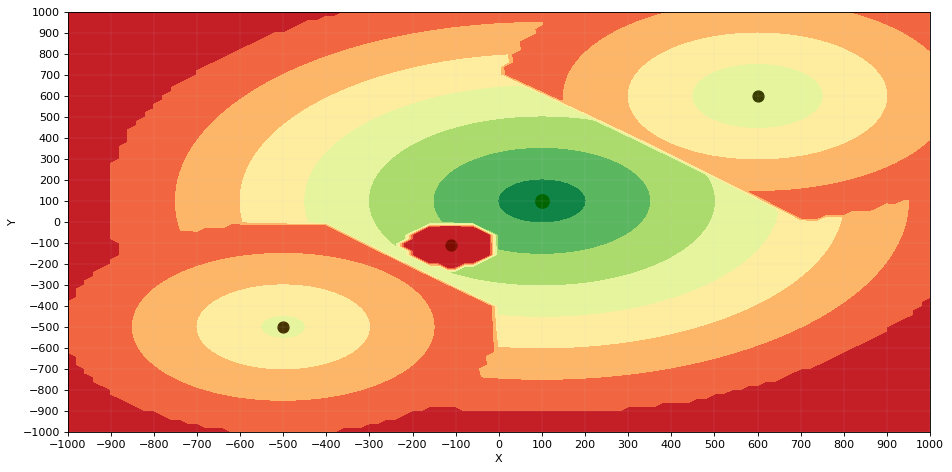

(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)

> Gráfico en 3D del Mapa de Búsqueda:


Output()

In [4]:
#@title clase MAPA DE BÚSQUEDA
Hash_configuracion_Mapa_Busqueda = "gANjX19tYWluX18KTWFwYUJ1c3F1ZWRhCnEAKYFxAX1xAihYBgAAAGxpbU1pbnEDShj8//9YBgAA AGxpbU1heHEETegDWAcAAABjYW50TWF4cQVLA1gKAAAATWF4aW1vc1Bvc3EGXXEHKF1xCChLZEtk ZV1xCShKDP7//0oM/v//ZV1xCihNWAJNWAJlXXELKEqR////SpH///9lZVgKAAAATWF4aW1vc1Zh bHEMXXENKEtkSzJLPEr1////ZVgLAAAATWF4T3B0aW1vSURxDksAWAEAAABYcQ9OWAEAAABZcRBO WAEAAABacRFOdWIu" #@param {type:"string"}

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.X, self.Y, self.Z = None, None, None
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):
            # define al azar
            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]
            auxVal = random.randint(-20, 100)
            # asigna
            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            # determina mejor
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i = i + 1
        return True

    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos

    @property
    def valMaximos(self):
        return self.MaximosVal

    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]

    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion, devSinNegativos=True):
        # Define la Función Heurística para evaluar una posicion del mapa
        devHeuristica = None
        minDist = None
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):
              # calcula la distancia a la posicion indicada
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  (math.fsum(sqerrors)**0.5) / 10
              # calcula la heurística correspondiente depende de la distancia
              # y si el valor del máximo es positivo o negativo
              if valMax >= 0:
                auxHeur = max(valMax - distPos, 0)
              else:
                auxHeur = min(valMax + distPos, 0)
              # si tiene heurística definida
              if (auxHeur != 0):
                # determina si es la menor distancia
                # o igual distancia con mayor heurística
                if (minDist is None) or (distPos < minDist) \
                  or ((distPos == minDist) and (devHeuristica < auxHeur)):
                    minDist = distPos
                    devHeuristica = auxHeur
        # Por las dudas controla que este definida y se  un valor positivo
        if devHeuristica is None:
          return 0
        else:
          if devSinNegativos:
            # ajusta la heurística para que no devuelva valores negativos
            # (puede complicar algunos métodos de selección de DEAP)
            return max(devHeuristica, 0)
          else:
            return devHeuristica


    def genDatosGraficos(self):
      if not((self.X is None) or (self.Y is None) or (self.Z is None)):
        # ya está definido, no hace falta re-generarlo
        return
      # define los datos para generar el gráfico
      rSep = (self.limMax-self.limMin)/100
      if rSep < 5:
        rSep = 5
      rX = np.arange(self.limMin, self.limMax+1, rSep)
      rY = np.arange(self.limMin, self.limMax+1, rSep)
      X, Y = np.meshgrid(rX, rY)
      # inicia los valores de aptitud
      Z = np.zeros((X.shape[0], X.shape[1]))
      # completa los valores de aptitud
      for i in range(X.shape[0]):
        for j in range(X.shape[1]):
          Z[i][j] = self.funcHeuristica( [ X[i][j], Y[i][j] ], False )
      #return X, Y, Z
      self.X, self.Y, self.Z = X, Y, Z
      return

    # método que se usa para generar gradiente de colores
    def colorFader(self, c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
        c1 = np.array(mpl.colors.to_rgb(c1))
        c2 = np.array(mpl.colors.to_rgb(c2))
        return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

    def genGrafico(self, tipoGraph, fig, mostrarEjes=True):
      es3D = (tipoGraph=="3D")
      # generar los datos X, Y, Z
      self.genDatosGraficos()
      # función que genera el gráfico en 3D
      # Genera el tipo de gráfico
      if es3D:
        ax = fig.add_subplot(111, projection='3d')
        # Surface 3D
        surf = ax.plot_surface(self.X, self.Y, self.Z, cmap=cm.RdYlGn,
                              linewidth=1, antialiased=False)
      else:
        ax = fig.add_subplot(111)
        # Superficie colores 2D (contourf)
        plt.contourf(self.X, self.Y, self.Z,  cmap=cm.RdYlGn)
      # muestra las posiciones de los máixmos como Scater
      for posi, vali in zip(self.posMaximos, self.valMaximos):
        valRel = abs(vali / self.valMaximoGlobal)
        c = self.colorFader('darkred', 'darkgreen', valRel)
        if es3D:
          ax.scatter(posi[0], posi[1], vali, color=c, s=100)
        else:
          ax.scatter(posi[0], posi[1], color=c, s=100)
      if es3D:
        ax.scatter(self.posMaximoGlobal[0], self.posMaximoGlobal[1], self.valMaximoGlobal, color='darkgreen', s=150)
      else:
        ax.scatter(self.posMaximoGlobal[0], self.posMaximoGlobal[1], color='darkgreen', s=150)
      # define ejes
      if mostrarEjes:
        gTicks = np.arange(self.limMin, self.limMax+1, 100)
        ax.set_xlabel("X")
        plt.xticks(gTicks)
        ax.set_ylabel("Y")
        plt.yticks(gTicks)
      plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.1)
      plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.1)
      if es3D:
        if mostrarEjes:
          ax.set_zlabel("Aptitud")
          #ax.zaxis.set_tick_params(labelsize=18)
        plt.grid(color='lightgrey', which='major', axis='z', linestyle='solid', linewidth=0.1)
      plt.tight_layout()
      return ax

    def graficar2D(self, muestraTitulo=True):
      if muestraTitulo:
        print("\n> Gráfico en 2D del Mapa de Búsqueda:")
      # determina tamaño de la figura
      fig = plt.figure(figsize=(12,6), dpi=80)
      # llama a la función
      # para generar el gráfico
      ax = self.genGrafico("2D", fig)
      plt.show()
      print("(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)")

    def cambiaSeleccionGrafico_3D(self, giroXY=270, elevZ=30):
      # determina tamaño de la figura
      fig = plt.figure(figsize=(12,6), dpi=80)
      # llama a la función
      # para generar el gráfico
      ax = self.genGrafico("3D", fig)
      # Gira la figura 3D
      ax.view_init(elevZ, giroXY)
      plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = -0.1,
            hspace = 0, wspace = 0)
      ax.margins(0,0,0)
      plt.show()
      print("(NOTA: color más ROJO significa PEOR aptitud, y más VERDE es MEJOR aptitud)")

    def graficar3D(self, muestraTitulo=True):
      if muestraTitulo:
        print("\n> Gráfico en 3D del Mapa de Búsqueda:")
      # Genera gráfico en 3D del mapa de búsqueda
      style = {'description_width': 'initial'}
      rotXY = IntSlider(description='Giro ejes XY', style=style, min=0, max=360, value=0, step=5)
      rotZ = IntSlider(description='Elevación eje Z', style=style, min=-150, max=150, value=0, step=5)
      ui3D = widgets.HBox([rotXY, rotZ])
      # usar esto para que cambie selección cada vez que se modifica algo
      out3D = widgets.interactive_output(self.cambiaSeleccionGrafico_3D, {'giroXY':rotXY, 'elevZ':rotZ})
      display(ui3D, out3D)


print("\nClase Mapa de Búqueda definida")

# si tiene la configuración definida, la carga sino crea nueva clase
if Hash_configuracion_Mapa_Busqueda != "":
  print("\n> Usando configuración de mapa de búsqueda definida en hash.")
  mapa = pickle.loads(codecs.decode(Hash_configuracion_Mapa_Busqueda.encode(), "base64"))
else:
  # sino define el Mapa de Búsqueda nuevo
  print("\n> Creando nuevo mapa de búsqueda.")
  mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                      cantMaximosLocales=CANT_MAXIMOS_LOCALES)

print("\n> Mapa de búsqueda definido:")
mapa.printInformacion()
print("\n> Hash del mapa de búsqueda definido: ")
print( codecs.encode(pickle.dumps(mapa), "base64").decode() )

# grafica el mapa de búsqueda
mapa.graficar2D()
mapa.graficar3D()

In [5]:
#@title clase auxiliar PARTICULA para Programación Genética

class ParticulaPG(object):

    def __init__(self, mapa):
        self.mapa = mapa
        self.pos = [random.randint(self.mapa.limMin, self.mapa.limMax) for _ in range(2)]
        self.valor = self.mapa.funcHeuristica(self.pos)


    def _reset(self):
        self.pos = []
        self.valor = -9999
        self.velocidad = []

    @property
    def heuristica(self):
        return round(self.valor, 2)

    @property
    def posicion(self):
        return self.pos


    def cambiarPosicion(self, nPos):
      if len(self.pos) == len(nPos):
        # cambia a la nueva posición indicada
        for i in range(len(self.pos)):
          self.pos[i] = nPos[i]

      # actualiza su heurística
      self.valor = self.mapa.funcHeuristica(self.pos)

      return self.pos

    def moverseAzar(self, distMaxima=100):

      for i in range(len(self.pos)):
          # ajusta la posición de la partícula al azar
          ajusteVel = random.uniform(self.mapa.limMin//10, self.mapa.limMax//10)
          if ajusteVel > distMaxima:
            ajusteVel = distMaxima
          self.pos[i] = self.pos[i] + int(ajusteVel)

          # revisa no haber superado los límites del mapa
          if self.pos[i] < self.mapa.limMin:
                self.pos[i] = self.mapa.limMin
          elif self.pos[i] > self.mapa.limMax:
                self.pos[i] = self.mapa.limMax

      # actualiza su heurística
      self.valor = self.mapa.funcHeuristica(self.pos)

      return self.pos

    def moverseAtraido(self, mejorCiclo, coefAtraccMejorCiclo=1.5, distMaxima=100):

        for i in range(len(self.pos)):
            # calcula el desplazamiento (velocidad) en base a la atracción a la mejor del ciclo
            ajusteVel = random.uniform(self.mapa.limMin//10, self.mapa.limMax//10)
            ajusteVel = ajusteVel + (coefAtraccMejorCiclo * random.uniform(0, 1) * (mejorCiclo.posicion[i]-self.pos[i]))
            if ajusteVel > distMaxima:
              ajusteVel = distMaxima

            # ajusta la posición de la partícula
            self.pos[i] = self.pos[i] + int(ajusteVel)

            # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)

        return self.pos

    def moverseAlrededor(self, mejorCiclo, radioMejor=100):

        for i in range(len(self.pos)):
            # ajusta posición dentro del radio de la mejor partícula
            self.pos[i] = random.randint(int(mejorCiclo.posicion[i]-radioMejor), int(mejorCiclo.posicion[i]+radioMejor))

            # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)

        return self.pos

print("\nClase ParticulaPG definida")

# Inicializa la lista de partículas (siempre la misma inicial)
listaPartPobla = []
for n in range(CANT_LISTAS_POBLA_PARTICULAS):
  auxPobla = []
  for i in range(CANT_PARTICULAS):
    p = ParticulaPG(mapa)
    auxPobla.append( p )
  print("\n", n, ") Lista de ParticulaPG con posiciones iniciales definida: ")
  for part in auxPobla:
    print(" ", part.posicion, " {", part.heuristica,"}")
  listaPartPobla.append(auxPobla)


Clase ParticulaPG definida

 0 ) Lista de ParticulaPG con posiciones iniciales definida: 
  [777, 342]  { 28.71 }
  [93, -927]  { 0 }
  [997, 356]  { 13.4 }
  [2, -338]  { 55.12 }
  [-979, 489]  { 0 }

 1 ) Lista de ParticulaPG con posiciones iniciales definida: 
  [-320, -929]  { 3.48 }
  [-399, 948]  { 1.61 }
  [-665, -363]  { 28.55 }
  [-646, 679]  { 5.57 }
  [-188, -16]  { 68.95 }

 2 ) Lista de ParticulaPG con posiciones iniciales definida: 
  [-245, -979]  { 0 }
  [139, 312]  { 78.44 }
  [641, 200]  { 19.79 }
  [572, -847]  { 0 }
  [-250, -984]  { 0 }


In [6]:
#@title DEFINE LAS PRIMITIVAS DEL CROMOSOMA A USAR EN LA BÚSQUEDA

# distancia máxima por defecto = 25% del espacio de búsqueda
PARAM_DIST_MAXIMA = (MAX_ESPACIO_BUSQ-MIN_ESPACIO_BUSQ)/4.0
PARAM_RADIO_MEJOR = PARAM_DIST_MAXIMA/2.0


# Inicializa variables auxiliares para mostrar movimiento partículas
ciclosPos = []
registraPosHistorico = False

# función auxiliar para obtener la mejor partícula de una lista
def devuelveMejor(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return None
  # obtiene la mejor partícula
  rankingParticulas = sorted(copy.deepcopy( particulas ), key=operator.attrgetter('heuristica'), reverse=True)
  mejorPart = rankingParticulas[0]
  return mejorPart

# función auxiliar para registrar posiciones de las particulas para mostrar
def registraPosParticulas(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return []
  auxLisPos = []
  for part in particulas:
    auxLisPos.append( copy.deepcopy( part.posicion ) )
  return auxLisPos

def seleccPartMover(particulas, cantPartMover):
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if cantPartMover <= 1:
    return sample(particulas, k=1)
  elif cantPartMover > len(particulas):
    return particulas
  else:
    return sample(particulas, k=cantPartMover)


## Define las primitivas a usar para ordenar la lista

def moverAzar(particulas, cantPartMover, distMaxima=PARAM_DIST_MAXIMA):
  ## función tipo Mutación de CE
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if distMaxima <= 0:
    distMaxima = 1
  # determina partículas a mover al azar
  partsMover = seleccPartMover(particulas, cantPartMover)
  # mueve las partículas al azar
  for part in partsMover:
    part.moverseAzar(distMaxima)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )
  return particulas

def moverAzarFuncHeurist(particulas, cantPartMover, distMaxima=PARAM_DIST_MAXIMA, mutate_factor=-2.5):
  ## función tipo HiperMutar de CLONALG
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if distMaxima <= 0:
    distMaxima = 1
  # determina partículas a mover al azar
  partsMover = seleccPartMover(particulas, cantPartMover)
  # mueve las partículas al azar
  for part in partsMover:
    # calcula distancia máxima en base a la heuristica
    distMaximaHeur = distMaxima * math.exp(mutate_factor * part.heuristica/100)
    if distMaximaHeur > 0:
      part.moverseAzar(distMaximaHeur)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )
  return particulas

def moverAtraidoAlMejor(particulas, cantPartMover, porcAtraccMejorCiclo=50, distMaxima=PARAM_DIST_MAXIMA):
  ## función tipo PSO
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  # obtiene la mejor partícula
  mejorPart = devuelveMejor(particulas)
  if distMaxima <= 0:
    distMaxima = 1
  if porcAtraccMejorCiclo > 0:
    coefAtraccMejorCiclo = porcAtraccMejorCiclo/100.0
  else:
    coefAtraccMejorCiclo = 0.0
  # determina partículas a mover al azar
  partsMover = seleccPartMover(particulas, cantPartMover)
  # ajusta a todas en base a la mejor
  for part in partsMover:
    part.moverseAtraido(mejorPart, coefAtraccMejorCiclo, distMaxima)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )
  return particulas

def moverAlrededorMejor(particulas, cantPartMover, radioMejor=PARAM_RADIO_MEJOR):
  ## función tipo Abejas
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  if radioMejor <= 0:
    radioMejor = 1000
  # obtiene la mejor partícula
  mejorPart = devuelveMejor(particulas)
  # determina partículas a mover al azar
  partsMover = seleccPartMover(particulas, cantPartMover)
  # ajusta a todas en base a la mejor
  for part in partsMover:
    part.moverseAlrededor(mejorPart, radioMejor)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )
  return particulas

def intercambiarPos(particulas, cantIntercambios):
  ## función tipo Cruzamiento de CE
  if particulas==None and particulas!="" and len(particulas)==0:
      return particulas
  # toma particulas de a pares
  # (primero y último, segundo y penúltimo,...)
  # teniendo en cuenta el máximo de cantIntercambios
  # e intercambia las posiciones
  mitadPart = len(particulas)//2
  if cantIntercambios <= 0 or cantIntercambios > len(particulas):
    cantIntercambios = 2
  if mitadPart > cantIntercambios:
    mitadPart = cantIntercambios
  for part1, part2 in zip( particulas[:mitadPart:1], particulas[:mitadPart-1:-1] ):
      nPos1 = []
      nPos2 = []
      # intercambia las posiciones para posiciones impares
      for i in range(len(part1.posicion)):
        if (i%2)==0:
          nPos1.append( part1.posicion[i] )
          nPos2.append( part2.posicion[i] )
        else:
          nPos2.append( part1.posicion[i] )
          nPos1.append( part2.posicion[i] )
      # indica las nuevas posiciones para las partículas
      # y actualiza la heurística
      part1.cambiarPosicion(nPos1)
      part2.cambiarPosicion(nPos2)
  # si corresponde guarda las nuevas posiciones para mostrar gráfico
  if registraPosHistorico:
    ciclosPos.append( registraPosParticulas(particulas) )
  return particulas

def mejorHeuristica(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return None
  # obtiene la mejor partícula
  rankingParticulas = sorted(copy.deepcopy( particulas ), key=operator.attrgetter('heuristica'), reverse=True)
  mejorPart = rankingParticulas[0]
  return int(mejorPart.heuristica)

def promedioHeuristica(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return None
  # calcula el promedio de la heuristica
  suma = 0.0
  for part in particulas:
    suma = suma + part.heuristica
  return int(suma/len(particulas))

def peorHeuristica(particulas):
  if particulas==None and particulas!="" and len(particulas)==0:
      return None
  # obtiene la peor partícula
  rankingParticulas = sorted(copy.deepcopy( particulas ), key=operator.attrgetter('heuristica'), reverse=False)
  mejorPart = rankingParticulas[0]
  return int(mejorPart.heuristica)

def pdiv(left, right):
    try:
        return int(left / right)
    except ZeroDivisionError:
        return 1


In [7]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

#@markdown > Función de Aptitud:
#@markdown - indica que es para maximizar.
#@markdown - determina la aptitud a partir del promedio de la distancia de cada partícula de los máximos locales y/o globales; además penaliza la cantidad de operadores del cromosoma (para reducir BLOAT).


# parámetro que se usa para penalizar expresiones muy largas
Cant_Operadores_Empieza_Penalizar = 20 #@param {type:"integer"}

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

# Configura las primitivas permitidas para usar
# algunas son configurables (opcionales) y otras no
pset = gp.PrimitiveSetTyped("MAIN", [str, int], str)
# para manejo de partículas
pset.addPrimitive(moverAzar, [str, int], str)
pset.addPrimitive(moverAzarFuncHeurist, [str, int], str)
pset.addPrimitive(moverAtraidoAlMejor, [str, int], str)
pset.addPrimitive(moverAlrededorMejor, [str, int], str)
pset.addPrimitive(intercambiarPos, [str, int], str)
#pset.addPrimitive(mejorHeuristica, [str], int)
#pset.addPrimitive(promedioHeuristica, [str], int)
#pset.addPrimitive(peorHeuristica, [str], int)
# para manejo de parámetros
pset.addPrimitive(operator.add, [int, int], int)
pset.addPrimitive(operator.sub, [int, int], int)
pset.addPrimitive(operator.mul, [int, int], int)
pset.addPrimitive(pdiv, [int, int], int)
pset.addPrimitive(max, [int, int], int)
pset.addPrimitive(min, [int, int], int)
pset.addEphemeralConstant("constante", lambda: random.randint(0,CANT_PARTICULAS), int)

pset.renameArguments(ARG0='Particulas')
pset.renameArguments(ARG1='CantParts')

print("\nPrimitivas definidas")

# indica que es la función de aptitud es para minimizar el error
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# función auxiliar para aplicar la expresión
def aplicaExpresion(individual, partPobla, debug=False):

  if debug:
    print("\n")
    print(individual)

  # Transforma la expresión del árbol en una función que se puede ejecutar
  try:
    func = toolbox.compile(expr=individual)
  except MemoryError:
    # si tira error por BLOAT devuelve un error muy grande para descartarlo
    return -9999, [], [],

  # guarda el histórico de posiciones por cada ciclo
  # para luego usar para mostrar el mejor
  global ciclosPos
  global registraPosHistorico
  ciclosPos = []
  ciclosPos.append( registraPosParticulas(partPobla) )
  registraPosHistorico = True

  # ejecuta las primitiva del individuo
  partOptimizada =  func( copy.deepcopy( partPobla ), len(partPobla) )

  # determina la particula mejor ubicada
  # al finalizar de evaluar el individuo
  mejorPart = devuelveMejor(partOptimizada)

  if debug:
    # devuelve sólo la mejor partícula
    print("Mejor Partícula: ", mejorPart.posicion, " { ", mejorPart.heuristica, " } ")

  # devuelve  la heurística de la mejor partícula, su posición y todas las generadas
  return mejorPart.heuristica, mejorPart.posicion, ciclosPos

# función auxiliar para calcular la aptitud
def calculaAptitud(individual):

  # calcula la cantidad de métodos aplicados
  cantMetodosAplicados = str(individual).count('(')

  # prueba con todas las lista de poblaciones de particulas
  # y devuelve el promedio de la heuristica
  # con los resultados de la mejor "corrida"
  promHeur = 0.0
  todasMejorPos = []
  todasCiclosPos = []
  for partPobla in listaPartPobla:
    # devuelve la heurística de la mejor partícula, su posición y todas las generadas
    auxHeur, auxPos, auxCiclosPos = aplicaExpresion(individual, partPobla, False)
    # calcula total heuristica par apromedio
    promHeur = promHeur + auxHeur
    # agrega mejor posicion
    todasMejorPos.append( auxPos )
    # agrega posiciones por ciclo unificado
    for i in range(len(auxCiclosPos)):
      if (len(todasCiclosPos)-1)<i:
        todasCiclosPos.append( [] )
      todasCiclosPos[i].extend( auxCiclosPos[i] )
  # calcula promedio
  promHeur = promHeur/len(listaPartPobla)
  # penalizando la cantidad de métodos alicados (si son más de 15 se considera peor)
  if cantMetodosAplicados >= Cant_Operadores_Empieza_Penalizar:
    promHeur = promHeur - cantMetodosAplicados
  # devuelve resultados
  return promHeur, todasMejorPos, todasCiclosPos

toolbox.register("evaluate", calculaAptitud)

print("\nFunción de Aptitud y Cromosoma definidos")


Primitivas definidas

Función de Aptitud y Cromosoma definidos


/usr/local/lib/python3.11/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral constante function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [8]:
#@title  OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Torneo' #@param ["Torneo", "Ranking"]

# Probabilidad del Cruzamiento
probab_cruzamiento = 0.5 #@param {type:"slider", min:0, max:1, step:0.05}

# Probabilidad del Mutación
probab_mutacion = 0.25 #@param {type:"slider", min:0, max:1, step:0.05}


# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Estocastica':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


In [9]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if mejorMax:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    else:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", auxBestInd, " {", round(auxBestIndApt, 3), "}")
        print("      Max: ", round(auxMax, 3), " / Promedio: ", round(auxProm, 3), " / Min: ", round(auxMin, 3))
    return auxBestInd, auxMax, auxProm, auxMin


def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit[0],
  return fitnesses


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos, o si llega a una heurística mayor a: ", round(MIN_HEURISTICA_FINALIZAR,3) )
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Cruzamiento: "+tipo_cruzamiento+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")


def mostrarPoblaDetalle(indivPobla, titulo=""):
  if titulo != "":
    print("\n" + titulo)
  for ind in indivPobla:
    print("\t", formatearIndividuo(ind), " { ", formatearAptitud(ind.fitness.values[0]), " } ")
  print("")

print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


In [10]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

# Muestra su información
mapa.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []
ciclosBestIndivMejorPos = []
ciclosBestIndivMejorPos = []
ciclosBestIndivCiclosPos = []

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = asignarAptitud(indivPobla)
ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)
auxIndiceBestInd = indivPobla.index( auxBestInd )
if auxIndiceBestInd >= 0:
  ciclosBestIndivMejorPos.append( fitnesses[auxIndiceBestInd][1] )
  ciclosBestIndivCiclosPos.append( fitnesses[auxIndiceBestInd][2] )
else:
  ciclosBestIndivMejorPos.append( [] )
  ciclosBestIndivCiclosPos.append( [] )


# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, cant_ind_selecc)

    # Realiza el Cruzamiento
    # por cada individuo seleccionado los clona (sino pueden afectarle los cambios)
    # y luego le busca una pareja al azar dentro de los seleccionados para generar 2 hijos
    indivHijos = []
    for hijo1 in list(map(toolbox.clone, indivSelecc)):
      if len(indivHijos) < len(indivPobla):
        # todavía falta generar hijos
        hijo2 = list(map(toolbox.clone, random.sample(indivSelecc, 1)))[0]
        # hace el cruzamiento
        toolbox.mate(hijo1, hijo2)
        del hijo1.fitness.values
        del hijo2.fitness.values
        # agrega 1er hijo
        indivHijos.append(hijo1)
        if len(indivHijos) < len(indivPobla):
          # agrega 2do hijo
          indivHijos.append(hijo2)
      else:
        break

    # controla que mantenga que los hijos
    # tenga la misma cantidad de individuos que la población original
    if len(indivHijos) != len(indivPobla):
      print("ERROR: distinta cantidad de individuos hijos ", len(indivHijos) , " | ", len(indivPobla))

    # Realiza la Mutación
    if random.random() < probab_mutacion:
      # ejecuta mutación:
      # selecciona al azar el individuo a mutar
      # y lo muta aplicando el método
      mutant = indivHijos[random.randint(0, len(indivHijos)-1)]
      # hace la mutación
      toolbox.mutate(mutant)
      del mutant.fitness.values

    # Evalua a los individuos hijos que salen de Cruzamiento & Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = asignarAptitud(invalid_ind)

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)
    if auxBestInd in indivPobla:
      auxIndiceBestInd = indivPobla.index( auxBestInd )
      if auxIndiceBestInd > 0:
          ciclosBestIndivMejorPos.append( fitnesses[auxIndiceBestInd][1] )
          ciclosBestIndivCiclosPos.append( fitnesses[auxIndiceBestInd][2] )
      else:
        ciclosBestIndivMejorPos.append( [] )
        ciclosBestIndivCiclosPos.append( [] )
    else:
        ciclosBestIndivMejorPos.append( [] )
        ciclosBestIndivCiclosPos.append( [] )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Individuo de la Corrida:", mejorIndCorrida, " { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")
print("   --> Mejores Posiciones Generadas: ", ciclosBestIndivMejorPos[mejorIndCorrida_ciclo], " { ", ciclosMaxAptitud[mejorIndCorrida_ciclo], " } ==")



** Máximos Generados:  4
  --> [100, 100] {  100  } 
  --> [-500, -500] {  50  } 
  --> [600, 600] {  60  } 
  --> [-111, -111] {  -11  } 

** Posición Máximo Óptimo:  [100, 100]  {  100  } **



-- Ciclo  0 --
 ++ Mejor Individuo: moverAlrededorMejor(moverAtraidoAlMejor(Particulas, 3), mul(2, 5))  { 90.66 }
      Max:  90.66  / Promedio:  65.3  / Min:  47.89

-- Ciclo  1 --
 ++ Mejor Individuo: moverAlrededorMejor(Particulas, CantParts)  { 84.7 }
      Max:  84.7  / Promedio:  68.55  / Min:  47.76

-- Ciclo  2 --
 ++ Mejor Individuo: moverAlrededorMejor(Particulas, CantParts)  { 86.84 }
      Max:  86.84  / Promedio:  68.84  / Min:  49.37

-- Ciclo  3 --
 ++ Mejor Individuo: moverAlrededorMejor(Particulas, CantParts)  { 86.85 }
      Max:  86.85  / Promedio:  72.82  / Min:  41.21

-- Ciclo  4 --
 ++ Mejor Individuo: moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), CantParts)  { 89.93 }
      Max:  89.93  / Promedio:  72.72  / Min:  45.03

-- Ciclo  5 --
 ++ Mejor Indiv

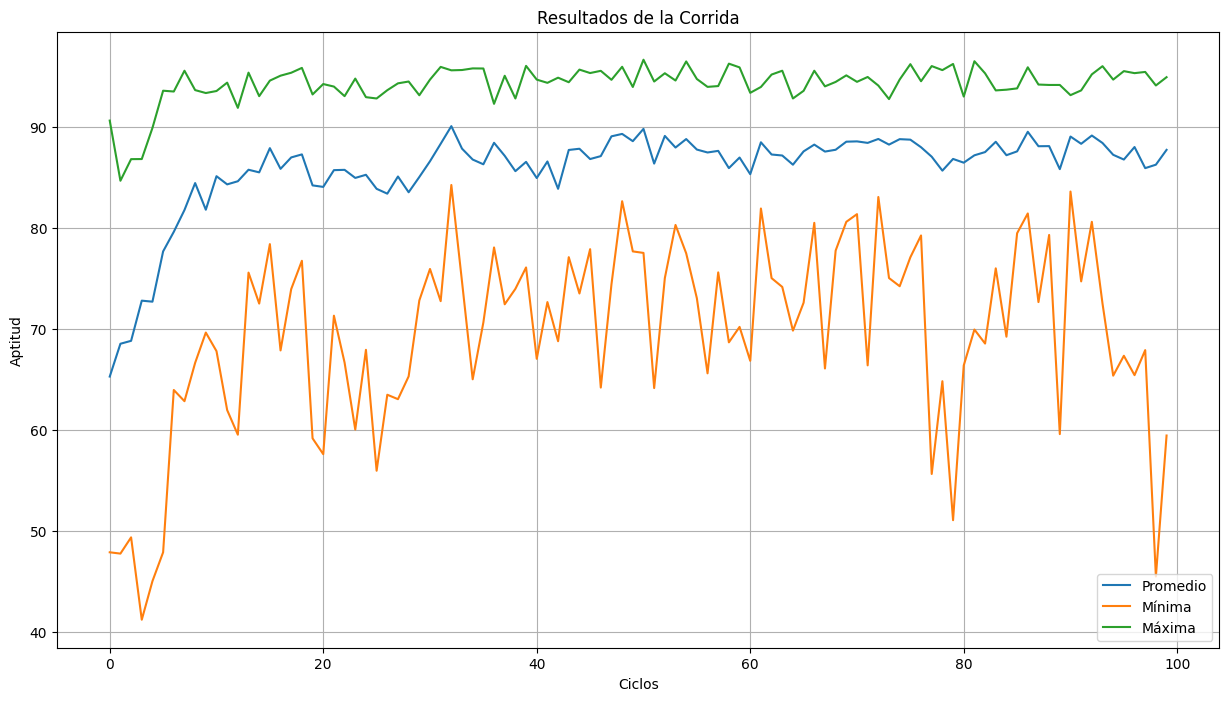

In [11]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
plt.show()


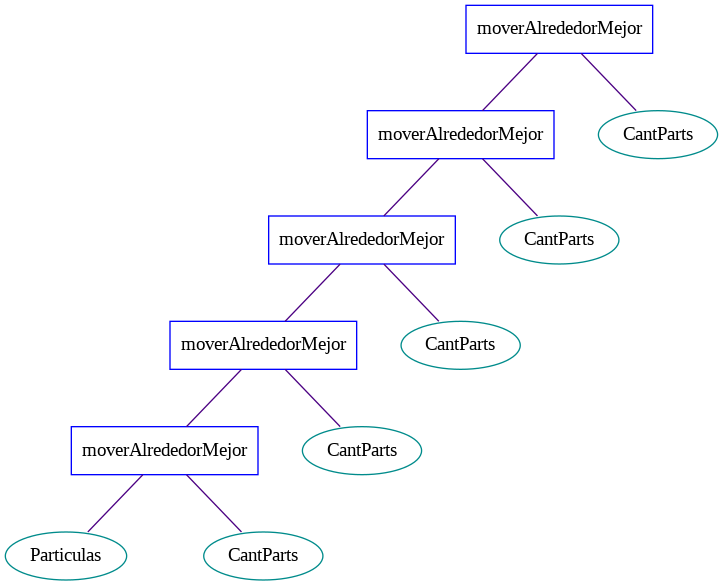


 moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), CantParts), CantParts), CantParts), CantParts)
   --> Mejores Posiciones Generadas:  [[114, 73], [73, 110], [138, 87]]  {  96.69  } ==

> Mapa de búsqueda:

** Máximos Generados:  4
  --> [100, 100] {  100  } 
  --> [-500, -500] {  50  } 
  --> [600, 600] {  60  } 
  --> [-111, -111] {  -11  } 

** Posición Máximo Óptimo:  [100, 100]  {  100  } **




In [12]:
#@title MOSTRAR GRAFICO DE LA EXPRESIÓN
## CORRESPONDIENTE AL MEJOR INDIVIDUO
nodes, edges, labels = gp.graph( mejorIndCorrida )

#g = pgv.AGraph()
g = pgv.AGraph(overlap=False, splines='polyline') # indica tipo de uniones
g.graph_attr['label']='' # título
g.graph_attr['ranksep']='0.6' # separación entre niveles
g.graph_attr['nodesep']='1.3' # separación en el mismo nivel

g.node_attr['shape']='box'
g.node_attr['color']='blue'
g.edge_attr['color']='indigo'
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]
    if labels[i]=='CantParts' or labels[i]=='Particulas':
      n.attr['shape']='oval'
      n.attr['color']='cyan4'
    elif str(labels[i]).isnumeric():
      n.attr['shape']='circle'
      n.attr['color']='dimgray'

# genera una imagen temporal con el árbol y la muestra
auxFile = tempfile.NamedTemporaryFile(suffix=".png")

g.draw(auxFile.name,format="png")
display(Image.open(auxFile.name))

print("\n", mejorIndCorrida )
print("   --> Mejores Posiciones Generadas: ", ciclosBestIndivMejorPos[mejorIndCorrida_ciclo], " { ", ciclosMaxAptitud[mejorIndCorrida_ciclo], " } ==")

print("\n> Mapa de búsqueda:")
mapa.printInformacion()


In [13]:
#@title MOSTRAR GRAFICO DE POSICIONES DE LAS PARTICULAS CICLO x CICLO

# Librerías especiales para usar
import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML

# método que se usa para generar gradiente de colores
def colorFader(c1, c2, mix=0.0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# Método que se ejecuta por cada frame para mostrar
def updatePlot(i, ciclosPos, scat, axi, posMejorCorrida, cicloMejorCorrida):
    if axi is None or ciclosPos is None:
      return scat,

    axi.set_xlabel('Operación: ' + str(i), fontsize=12)
      # Si no es el último ciclo, muestra también el global
    if i<len(ciclosPos):
      if len(ciclosPos[i])>0:
          if MOSTRAR_HISTORICO_MOVIMIENTO:
              # Coloca nuevas posiciones correspondientes al ciclo
              # Separa las coordenadas x, y de las posiciones en el ciclo i
              X, Y = zip(*ciclosPos[i])
              ## --en Rojo: posiciones de las particulas de cada ciclo
              axi.scatter(X, Y, color='red')
          else:
              # Hace mover a las Partículas
              scat.set_offsets(ciclosPos[i])

    if i>=cicloMejorCorrida:
      if posMejorCorrida is not None:
          ## --en Violeta: Mejor posición de las partículas
          if len(posMejorCorrida) == 2 and isinstance(posMejorCorrida[0], int) and  isinstance(posMejorCorrida[1], int):
              axi.scatter(posMejorCorrida[0], posMejorCorrida[1], color='violet', s=100)
          else:
              X, Y = zip(*posMejorCorrida)
              axi.scatter(X, Y, color='violet', s=100)

    # Devuelve una lista de "artistas" para dibujar,
    # en este caso es sólo uno por lo que se pone una coma final
    return scat,

# Función para preparar el gráfico
def PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos, partMejorCorrida, cicloMejorCorrida, textoTitulo, textoDesc):

    fig = plt.figure(figsize=(12,6), dpi=80)
    #ax = fig.add_subplot(111)
    ax = mapa.genGrafico("2D", fig, False)
    plt.close()

    # Define el tamaño de la figura
    ax.axis([MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ])

    # Separa las coordenadas x, y de las posiciones en el ciclo inicial
    X, Y = zip(*ciclosPos[0])
    ## --en Azul: posiciones de las posiciones de cada ciclo
    scat = ax.scatter(X, Y, color='blue')

    # Muestra título y texto debajo
    ax.set_title(textoTitulo)
    #ax.set_ylabel(textoDesc, fontsize=11)

    # Luego setea la animación usando los dos métodos anteriores
    cant = len(ciclosPos)+1
    ani = animation.FuncAnimation(fig, updatePlot,
                                  frames=cant, interval=cant,
                                  fargs=(ciclosPos, scat, ax, partMejorCorrida, cicloMejorCorrida),
                                  blit=True, repeat=False)

    return ani

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False
textoTitulo = "Posición de las Partículas obtenidas de movimientos generados por PG"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejores Particulas:  ' + str(ciclosBestIndivMejorPos[mejorIndCorrida_ciclo]) + ' { ' + str(ciclosMaxAptitud[mejorIndCorrida_ciclo]) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (más ROJO PEOR aptitud, y más VERDE es MEJOR aptitud) - '
textoDesc = textoDesc + '\n-- Particula (AZUL) - Mejor Particula (VIOLETA) -- '

# Prepara el gráfico
ani = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosBestIndivCiclosPos[mejorIndCorrida_ciclo], ciclosBestIndivMejorPos[mejorIndCorrida_ciclo], len(ciclosBestIndivCiclosPos[mejorIndCorrida_ciclo])-1, textoTitulo, textoDesc)

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(ani)
print(textoDesc)


** Posición Máximo Óptimo a buscar : [100, 100] { 100 } **
== Mejores Particulas:  [[114, 73], [73, 110], [138, 87]] { 96.69 } ==
-- Colores:  Máximos Locales (más ROJO PEOR aptitud, y más VERDE es MEJOR aptitud) - 
-- Particula (AZUL) - Mejor Particula (VIOLETA) -- 


In [14]:
#@title PRUEBA CON OTROS VALORES INICIALES DE PARTICULAS - GRAFICO DE POSICIONES DE LAS PARTICULAS CICLO x CICLO
print("\n", mejorIndCorrida )

# inicializa otras partículas
partPobla2 = []
for i in range(CANT_PARTICULAS):
  p = ParticulaPG(mapa)
  partPobla2.append( p )
print("\nLista de NUEVAS ParticulaPG con posiciones iniciales definida: ")
for part in partPobla2:
   print(" ", part.posicion, " {", part.heuristica,"}")

# aplica el individuo
mejorHeuristica2, posMejorCorrida2,  ciclosPos2 = aplicaExpresion(mejorIndCorrida, partPobla2, True)
print("\n\n")

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False
textoTitulo = "Posición de NUEVAS Partículas obtenidas de movimientos generados por PG"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejor Particula: ' + str(mejorIndCorrida) + ' { ' + str(round(mejorIndCorrida.fitness.values[0], 3)) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (más ROJO PEOR aptitud, y más VERDE es MEJOR aptitud) - '
textoDesc = textoDesc + '\n-- Particula (AZUL) - Mejor Particula (VIOLETA) -- '

# Prepara el gráfico
ani = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos2, posMejorCorrida2, len(ciclosPos2)-1, textoTitulo, textoDesc)

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(ani)
print(textoDesc)


 moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), CantParts), CantParts), CantParts), CantParts)

Lista de NUEVAS ParticulaPG con posiciones iniciales definida: 
  [895, -148]  { 16.72 }
  [373, 981]  { 15.65 }
  [491, -542]  { 24.83 }
  [973, 199]  { 5.23 }
  [330, -873]  { 0.02 }


moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), CantParts), CantParts), CantParts), CantParts)
Mejor Partícula:  [214, 129]  {  88.24  } 






** Posición Máximo Óptimo a buscar : [100, 100] { 100 } **
== Mejor Particula: moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(moverAlrededorMejor(Particulas, CantParts), CantParts), CantParts), CantParts), CantParts) { 96.687 } ==
-- Colores:  Máximos Locales (más ROJO PEOR aptitud, y más VERDE es MEJOR aptitud) - 
-- Particula (AZUL) - Mejor Particula (VIOLETA) -- 
